In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
import re

In [87]:
def Plot(X_data, Y_data, input_function, plot_name='plot_name', plot_title='plot_title', x_label='x_label', y_label='y_label', Y_absolute_sigma = 0, scientific_view = False, print_cross = True, save_as_csv = False, to_latex = False, save_fig=True): 

    X_data = np.array(X_data)
    Y_data = np.array(Y_data)

    # преобразования функции к виду для питона
    inp = input_function
    fun = inp.replace('e', 'np.e')
    fun = fun.replace('^', '**')
    fun = fun.replace('log', 'np.log10')
    fun = fun.replace('ln', 'np.log')


    # пропишем функции
    num_coef = len(re.findall('a[0-9]', fun))

    approx1 = lambda x,a0: eval(fun)
    approx2 = lambda x,a0,a1: eval(fun)
    approx3 = lambda x,a0,a1,a2: eval(fun)
    approx4 = lambda x,a0,a1,a2,a3: eval(fun)
    approx5 = lambda x,a0,a1,a2,a3,a4: eval(fun)
    approx6 = lambda x,a0,a1,a2,a3,a4,a5: eval(fun)

    approx = eval('approx'+'{}'.format(num_coef))

    # используем функцию curve_fit
    beta_opt1, beta_cov1 = curve_fit(approx, X_data, Y_data, absolute_sigma = Y_absolute_sigma)


    # коэффициенты
    a = beta_opt1

    #получим погрешности для коэффициентов
    sigma_a = np.diag(beta_cov1)

    # относистельные погрешности на коэффиценты
    rel_sigma_a = 100* sigma_a/abs(a)

    # подсчитаем стандартную ошибку аппроксимации
    residuals1 = Y_data - approx(X_data,*beta_opt1)
    fres1 = sum(residuals1**2)
    S_e = np.sqrt(fres1/len(X_data))



    # график
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('white')


    # определяем массив точек по оси Ох и строим график аппроксимации
    dots = np.arange(X_data[0], max(X_data) + 0.0001, 0.01)
    ax.plot(dots, approx(dots, *beta_opt1), '--', lw = 2)

    # это строит "точками" твои начальные данные
    ax.scatter(X_data, Y_data, color = 'red', s = 15)

    # в легенду запишем функцию аппроксимации с определнными коэффициентами
    if scientific_view == True:
        tr1 = re.sub(r'a[0-9]', '{:.3E}', inp)
    else:
        tr1 = re.sub(r'a[0-9]', '{%.3f}', inp)
    tr = inp.replace('ln', '\ln ')
    tr1 = tr1.replace('e^', 'exp')
    tr1 = tr1.replace('**', '^')
    tr1 = tr1.replace('*', ' \cdot ')

    tr1 = '$ y(x) = ' + tr1 + '$'
    # выстроим верный порядок коэффициентов
    order = re.findall('a([0-9])', fun)
    a_ord = dict(zip(order, a))
    a_ord = dict(sorted(a_ord.items()))
    a_ord = tuple(a_ord.values())

    # это легенда в графике
    if scientific_view == True:
        ax.legend([tr1.format(*a_ord)], loc='best', shadow=True) 
    else:
        ax.legend([tr1%a_ord], loc='best', shadow=True) 

    # название графика и подписи к осям
    ax.set_title(plot_title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    # это создает сетку и делает маркеры на осях
    ax.minorticks_on()
    ax.grid(which='minor', color = 'gray', linestyle = ':', linewidth = 0.5)
    ax.grid(which='major', linewidth = 0.5)

    # это кресты погрещности, но только вдоль оси Y
    if print_cross == True:
        plt.errorbar(X_data, Y_data, fmt = 'ro', markersize = '4', yerr = S_e, capsize = 2, elinewidth = 1, capthick = 1, ecolor = 'black')

    # это для пределов отображения графика
    # plt.xlim (-10, 850)
    # plt.ylim (-10, 245)

    # сохраним график в картинку?
    if save_fig == True:
        plt.savefig('pictures/'+plot_name+'.png', dpi=400)


    # вывод коэффициентов и погрешностей

    # названия коэффициентов в порядке ввода их в начале
    names = []
    for i in range(num_coef):
        names.append(r'a_{}'.format(i))
    # непосредственно создание pandas таблицы
    param = np.concatenate((np.array(a),np.array(sigma_a), np.array(rel_sigma_a))).reshape(3,num_coef).T
    pd.set_option('display.float_format', lambda x: '{:.3E}'.format(x))
    output = pd.DataFrame(param, columns = ['coeffs_values', 'standard error', 'relative se, %'])
    output.insert(0, value = names, column = 'coeffs')

    # сохраним в таблицу csv
    if save_as_csv == True:
        output.to_csv('output.csv', index = False)

    # выведем таблицу
    print('Coeffs table: \n')
    print(output)

    # выведем погрешность по оси Oy
    print('\nStandart_error_Y = {:.3E}'.format(S_e))

    # проебразование таблицы коэффициентов в латех код
    if to_latex == True:
        latex_output = output.to_latex(index = False, position = 'H', caption = 'Коэффициенты аппроксимации', label = 'coeffs_table')
        print('\n\nLatex code of coeffs table: \n')
        print(latex_output)
        with open('coeffs_table.tex', 'w') as tf:
            tf.write(latex_output)

    # покажем график
    plt.show()

    pass

Coeffs table: 

  coeffs  coeffs_values  standard error  relative se, %
0    a_0      4.461E+00       3.571E-02       8.006E-01
1    a_1     -1.279E+00       7.143E-01       5.587E+01

Standart_error_Y = 2.766E-02


Latex code of coeffs table: 

\begin{table}[H]
\centering
\caption{Коэффициенты аппроксимации}
\label{coeffs_table}
\begin{tabular}{lrrr}
\toprule
coeffs &  coeffs\_values &  standard error &  relative se, \% \\
\midrule
   a\_0 &      4.461E+00 &       3.571E-02 &       8.006E-01 \\
   a\_1 &     -1.279E+00 &       7.143E-01 &       5.587E+01 \\
\bottomrule
\end{tabular}
\end{table}



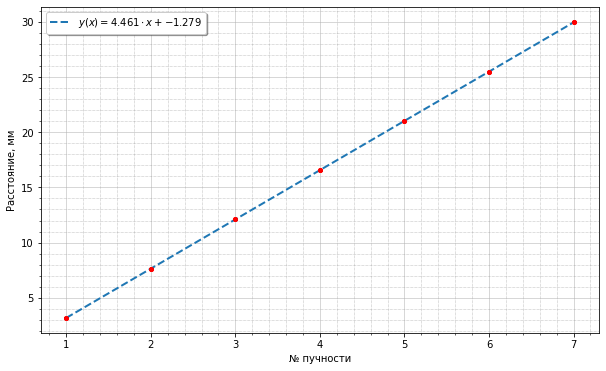

In [88]:

#######################################################################################################################

# имя нашего графика (имя картинки)
plot_name = 'gr1'

# имя на самом графике сверху
plot_title = ''

# подпись к оси Y
y_label = 'Расстояние, мм'

# подпись к оси X
x_label = '№ пучности'

# введем данные
X_data = np.array([1,2,3,4,5,6,7])
Y_data = np.array([3.2, 7.65, 12.1, 16.55, 21, 25.45, 30])

# известна ли погрешность на данные Y, можно передать как одно число, так и массив, если известна погрешность для каждого значения из Y_data
Y_absolute_sigma = 0.05

# примеры функций аппроксимаций
fun_ex = {'linear':'a0*x+a1', 'poly_2':'a0*x**2+a1*x+a2', 'poly_3':'a0*x**3+a1*x**2+a2*x+a3','exp':'e^(a0*x+a1)+a2', 'ln':'ln(a0*x+a1)+a2'}

# определим функцию аппроксимации
input_function = 'a0*x+a1'
# # можно также определить функцию используя словарь примеров
# input_function = fun_ex['linear']

#запись чисел в легенде в 'научном' виде
scientific_view = False

# кресты погрешности рисуем? 
print_cross = True 

# конвертируем таблицу коэффициентов в Latex код? Чтобы оно работало в latex надо
# импортировать пакет \usepackage{booktabs}
to_latex = True 

# сохраняем табличку с коэффициентами и погрешностями в csv?
save_as_csv = False

# сохраняем картинку графика?
save_fig = True

##########################################################################################################################

Plot(X_data, Y_data, input_function, plot_name, plot_title, x_label, y_label, Y_absolute_sigma, scientific_view, print_cross, save_as_csv, to_latex, save_fig)


Coeffs table: 

  coefs  coeffs_values  standard error  relative se, %
0   a_0      1.603E-01       6.982E-03       4.356E+00
1   a_1      7.096E-01       4.982E-04       7.021E-02

Standart_error_Y = 2.195E-01


Latex code of coeffs table: 

\begin{table}[H]
\centering
\caption{Коэффициенты аппроксимации}
\label{coeffs_table}
\begin{tabular}{lrrr}
\toprule
coefs &  coeffs\_values &  standard error &  relative se, \% \\
\midrule
  a\_0 &      1.603E-01 &       6.982E-03 &       4.356E+00 \\
  a\_1 &      7.096E-01 &       4.982E-04 &       7.021E-02 \\
\bottomrule
\end{tabular}
\end{table}



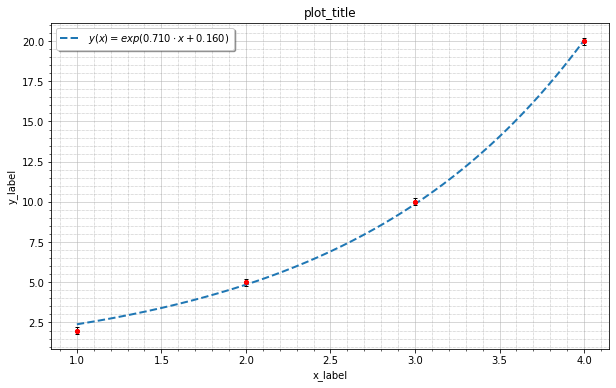

In [76]:
Plot([1,2,3,4], [2,5,10,20], 'e^(a0*x+a1)', save_fig = False, to_latex = True)